<a href="https://colab.research.google.com/github/chengharv-pen/Titanic-Survival-Analysis/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DISCLAIMER:
The grid searches for `LogisticRegression` and `Perceptron` classifiers took 21.787s and 25.898s respectively to run on my computer. The specs are below:
- Operating System: Linux Mint
- Processor: AMD Ryzen 7 5825U with Radeon Graphics 2.00 GHz
- RAM: 16 GB
- Video Card: NVIDIA GeForce RTX 3050 Ti Laptop GPU

On Google Colab's hosted `v5e-1` TPU runtime, it took 42s and 55s respectively.

See the report in the [GitHub Repository](https://github.com/chengharv-pen/Titanic-Survival-Analysis/blob/main/Report.pdf).

# If on Google Colab, run the cells below

It is recommended to change to the T4 GPU runtime. Total runtime for all cells should not take more than 5min.

In [1]:
!git clone https://github.com/chengharv-pen/Titanic-Survival-Analysis.git

import os
os.chdir("Titanic-Survival-Analysis")

Cloning into 'Titanic-Survival-Analysis'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 24 (delta 2), reused 21 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 981.84 KiB | 18.18 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
# sanity check
!pwd

/content/Titanic-Survival-Analysis


# Data pre-processing

Using the provided modified dataset of Titanic passengers (original dataset
available here), build a machine learning model to predict the survival outcome.
Based on information about each passenger—such as sex, age, ticket class, and
fare—your model should determine whether the passenger survived or not.

Note: Use the random seed (random state) of 433.

## Part 1: Use statistical methods and graphs/plots to describe your dataset.

For this notebook, the libraries used are:
- numpy
- pandas
- matplotlib
- seaborn
- scikit-learn
- imbalanced-learn

In [3]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 16.0 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import classification_report, confusion_matrix

### 1. Loading and exploring the data

Please change the directory appropriately.
In my case, I was using PyCharm and put the Titanic.csv file in the data directory, and this notebook in the project's root directory

```text
project-root/
├── data/
│ └── Titanic.csv
├── titanic-analysis.ipynb
└── README.md
```

In [5]:
titanic_df = pd.read_csv('data/Titanic.csv') # for local testing in PyCharm
# titanic_df = pd.read_csv('/content/sample_data/Titanic.csv') # for Google Colab (NOT NEEDED ANYMORE)
titanic_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [6]:
# Here, I noticed that there are null Age values, by comparing the count of Age with the count of PassengerId
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# Let's check for the total count of null values for each column
titanic_df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2


### 2. Handling null values in Age and Embarked columns

In [8]:
# We will decide to drop the rows with null values for column Embarked, since it contains categorical values
titanic_df = titanic_df[titanic_df['Embarked'].notna()]

# 177/891 rows of Age with null value is 20% of the dataset (rounded up).
# Dropping the rows with null value would be inappropriate, since we would lose a lot of information for the models.
# We need to use another way to handle null values...

### NOT USED ANYMORE ###
# We will fill the null Age values with the Age column's median
# print(f"Median of Age column: {titanic_df['Age'].median()}")
# titanic_df.loc[:, 'Age'] = titanic_df['Age'].fillna(titanic_df['Age'].median())
### NOT USED ANYMORE ###

# I take it back, it skews too many counts on the median... 20% of the dataset is A LOT
# Let's try group-based median imputation
titanic_df.loc[:, 'Age'] = titanic_df.groupby(['Sex', 'Pclass'])['Age'] \
                              .transform(lambda x: x.fillna(x.median()))

# Verify that no rows with null values remain
titanic_df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


### 3. Visualizing data distributions using histograms

Keep in mind the imbalance in the distribution of Survived, the label that we want to predict. We will have to deal with this in later questions/sub-questions.

Survived class distribution: Counter({0: 549, 1: 340})


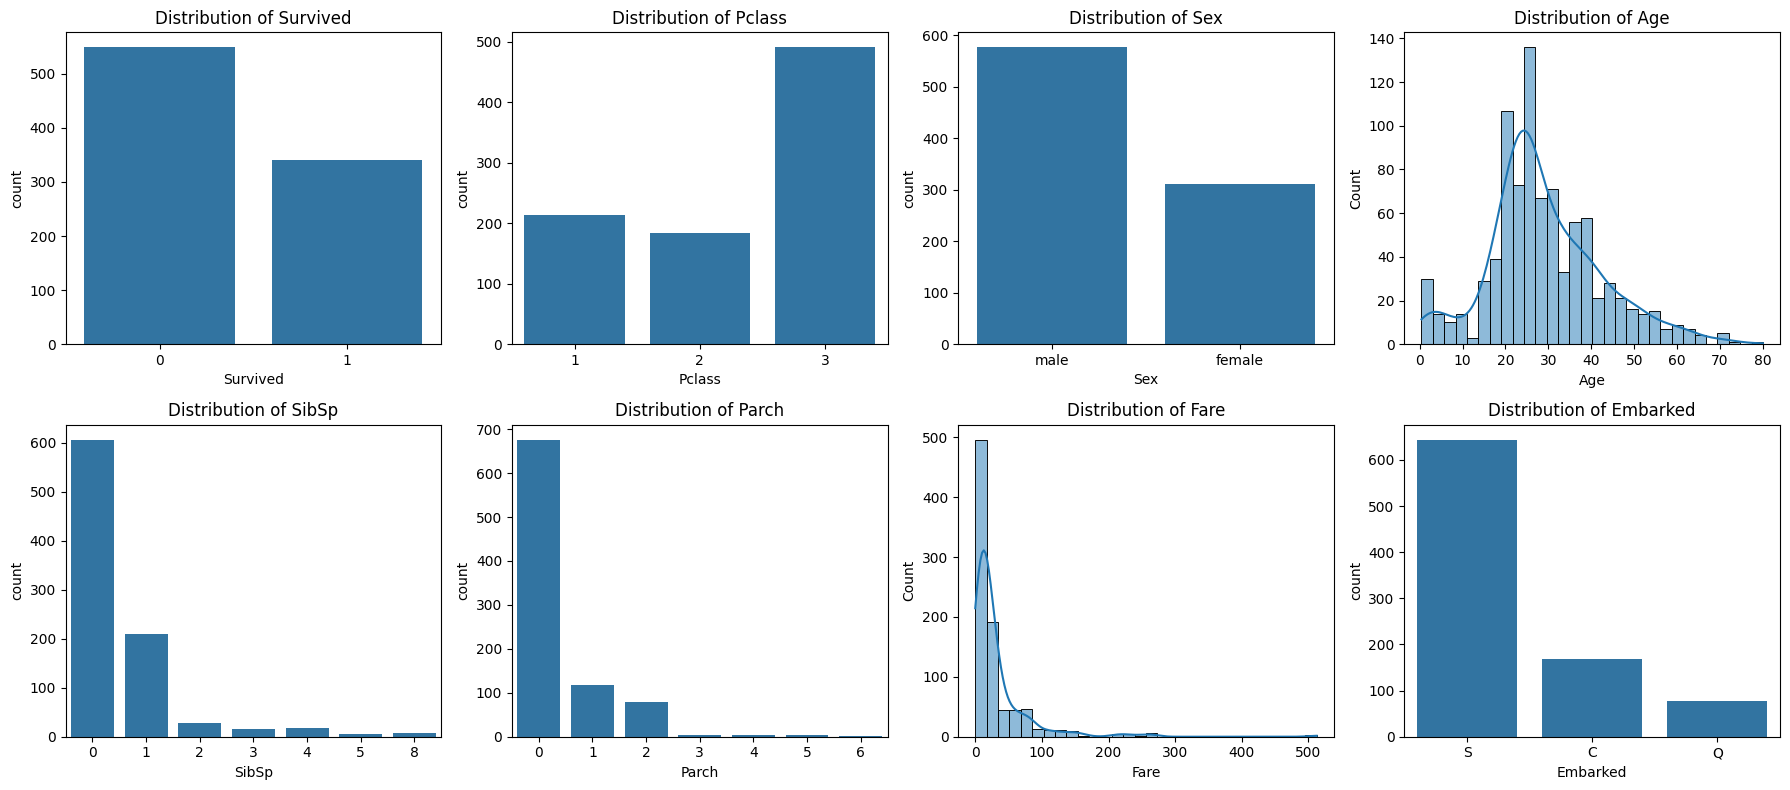

In [9]:
print("Survived class distribution:", Counter(titanic_df['Survived']))

dataset_cols = titanic_df.columns
dataset_cols = dataset_cols.drop(['PassengerId'])

# Set up the figure for histograms
plt.figure(figsize=(18, 8))

for i, col in enumerate(dataset_cols, 1):
    plt.subplot(2, 4, i)
    if titanic_df[col].dtype in ['int64', 'float64'] and titanic_df[col].nunique() > 10:
        sns.histplot(titanic_df[col], bins=30, kde=True)
    else:
        sns.countplot(x=titanic_df[col])
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

### 4. Creating heatmap to visualize correlation between variables

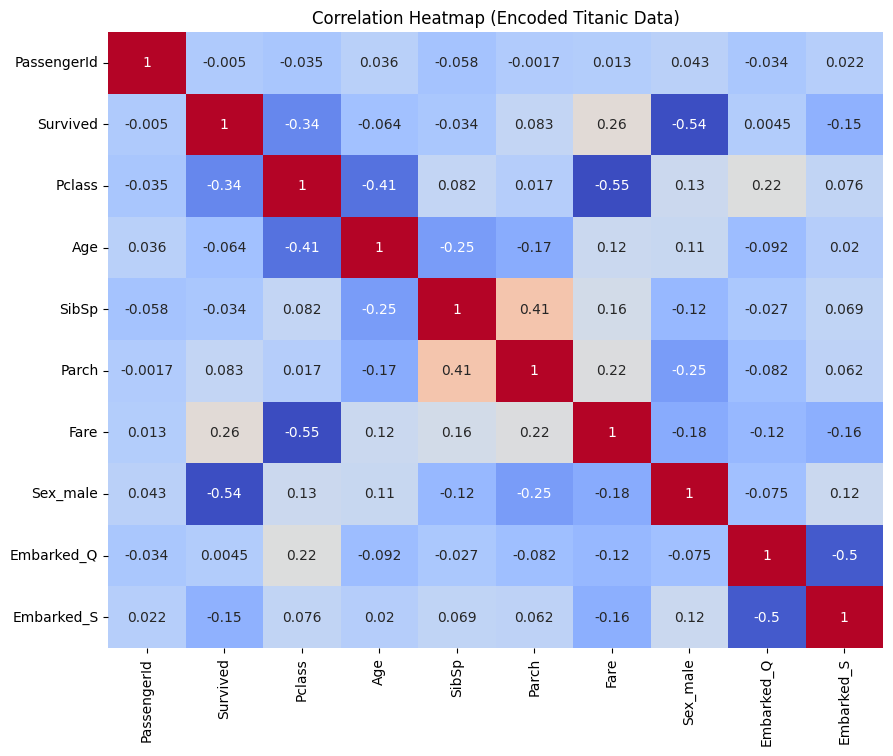

In [10]:
# Numerical and Categorical heatmap (using encoding)
titanic_encoded = pd.get_dummies(titanic_df, drop_first=True)

plt.figure(figsize=(10,8))
sns.heatmap(titanic_encoded.corr(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlation Heatmap (Encoded Titanic Data)")
plt.show()

## Part 2: Split your dataset into train and test sets with a 80:20 ratio. Use the train_test_split tool from scikit-learn.

### 1. Encoding categorical columns, and using OrdinalEncoder for columns with meaningful order

In [11]:
# We should encode the categorical columns before train_test splitting
# One-hot encode nominal categorical columns
one_hot_encoder = OneHotEncoder(drop=None, sparse_output=False)
encoded_cols = one_hot_encoder.fit_transform(titanic_df[['Sex', 'Embarked']])

encoded_df = pd.DataFrame(
    encoded_cols,
    columns=one_hot_encoder.get_feature_names_out(['Sex', 'Embarked']),
    index=titanic_df.index # this prevents "Ghost NaNs"
)
titanic_encoded = pd.concat([titanic_df, encoded_df], axis=1).drop(columns=['Sex', 'Embarked'])
print(titanic_encoded.isnull().sum())


# We should use Ordinal Encoding on the Pclass column, since it has a natural/meaningful order or ranking among its categories...
ordinal_encoder = OrdinalEncoder(categories=[[1, 2, 3]]) # for some reason, we need the categories array to be in ASC order.
encoded = ordinal_encoder.fit_transform(titanic_encoded[['Pclass']])

# Flip it so that 1st class is highest rank, because linear models interpret higher numbers as "more of something"
# 3rd class (Lower) -> 0.0
# 2nd class (Middle) -> 1.0
# 1st class (Upper) -> 2.0
titanic_encoded['Pclass'] = np.max(encoded) - encoded

titanic_encoded

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Sex_female     0
Sex_male       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0.0,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,2,1,2.0,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,1,0.0,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,4,1,2.0,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,5,0,0.0,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,1.0,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,1.0
887,888,1,2.0,19.0,0,0,30.0000,1.0,0.0,0.0,0.0,1.0
888,889,0,0.0,21.5,1,2,23.4500,1.0,0.0,0.0,0.0,1.0
889,890,1,2.0,26.0,0,0,30.0000,0.0,1.0,1.0,0.0,0.0


### 2. Using train_test_split to split the data properly

In [12]:
X = titanic_encoded.drop(['PassengerId', 'Survived'], axis=1)  # no need for PassengerId feature
y = titanic_encoded['Survived'] # y labels needs to be the Survived column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=433)

# we should further split the training dataset further into training/validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=433)

### 3. Resampling the training data for LogisticRegression, because our dataset is imbalanced
This may result in decreased accuracy, but we get noticeably higher recall values for LogisticRegression.

We will use the non-resampled data for Perceptron later.

In [13]:
print("\nOriginal class distribution:", Counter(y_train))

smote = SMOTE(sampling_strategy='auto', random_state=433)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:", Counter(y_train))

print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)


Original class distribution: Counter({0: 347, 1: 221})
Resampled class distribution: Counter({1: 347, 0: 347})

Training set size: (694, 10)
Test set size: (178, 10)


### 4. Scaling the features (this is really important for linear models!!!)

In [14]:
scaler = StandardScaler()

# fit only on training data, then transform
# (so only X_train influences the scaler, and its scaling is applied to X_val and X_test)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Logistic Regression Model

## Part 1: Build and train a Logistic Regression model using scikit-learn. Explore the parameters of the model in scikit-learn, and aim for higher classification accuracies.

### 1. Initialize hyperparameter grid and Logistic Regression model

In [15]:
logreg_model = LogisticRegression(random_state=433)

hyperparameter_grid = {
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "C": np.logspace(-3, 3, 500),
    "max_iter": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000],
    "class_weight": [None, "balanced"],
}

### 2.1. Perform randomized search on hyperparameter grid

In [16]:
random_search = RandomizedSearchCV(
    estimator=logreg_model,
    param_distributions=hyperparameter_grid,
    n_iter=100,              # number of random parameter samples
    scoring="accuracy",     # metric to optimize
    cv=5,                   # 5-fold cross-validation
    random_state=433,
    n_jobs=-1
)

# fit on training set
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

Best Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'class_weight': None, 'C': np.float64(10.092715146305718)}
Best CV Accuracy: 0.7781044729433845


### 2.2. Perform grid search on hyperparameter grid

In [17]:
grid_search = GridSearchCV(
    estimator=logreg_model,
    param_grid=hyperparameter_grid,
    scoring="accuracy",     # metric to optimize
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1
)

# fit on training set
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'C': np.float64(1.9705578015018004), 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Accuracy: 0.7781044729433845


### 3. Comparing grid and random search's validation accuracies

In [18]:
# evaluate on validation set
grid_val_score = random_search.score(X_val, y_val)
random_val_score = grid_search.score(X_val, y_val)
print("Grid Search Validation Accuracy:", grid_val_score)
print("Random Search Validation Accuracy:", random_val_score)

# Interesting, not much difference between Grid/Random Search validation accuracies...
# Still keep results for both searches, might be something to talk about in the report

Grid Search Validation Accuracy: 0.8181818181818182
Random Search Validation Accuracy: 0.8111888111888111


## Part 2: Report and discuss the performance of your developed model on both the train and test sets (separately). You can use scikit-learn’s classification report tool.

In [19]:
# Note: grid/random_search currently holds the Perceptron model with the best hyperparameters from the search
# It is already fit to X_train and y_train, so all we need to do is predicting the y values

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print("=== GRID - Training Set Performance ===")
print(classification_report(y_train, y_train_pred))

print("=== GRID - Training Confusion Matrix ===")
print(confusion_matrix(y_train, y_train_pred))

print("=== GRID - Test Set Performance ===")
print(classification_report(y_test, y_test_pred))

print("=== GRID - Test Confusion Matrix ===")
print(confusion_matrix(y_test, y_test_pred))

=== GRID - Training Set Performance ===
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       347
           1       0.79      0.76      0.78       347

    accuracy                           0.78       694
   macro avg       0.78      0.78      0.78       694
weighted avg       0.78      0.78      0.78       694

=== GRID - Training Confusion Matrix ===
[[277  70]
 [ 82 265]]
=== GRID - Test Set Performance ===
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       106
           1       0.77      0.74      0.75        72

    accuracy                           0.80       178
   macro avg       0.80      0.79      0.79       178
weighted avg       0.80      0.80      0.80       178

=== GRID - Test Confusion Matrix ===
[[90 16]
 [19 53]]


In [20]:
y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)

print("=== RANDOM - Training Set Performance ===")
print(classification_report(y_train, y_train_pred))

print("=== RANDOM - Training Confusion Matrix ===")
print(confusion_matrix(y_train, y_train_pred))

print("=== RANDOM - Test Set Performance ===")
print(classification_report(y_test, y_test_pred))

print("=== RANDOM - Test Confusion Matrix ===")
print(confusion_matrix(y_test, y_test_pred))

=== RANDOM - Training Set Performance ===
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       347
           1       0.79      0.76      0.78       347

    accuracy                           0.78       694
   macro avg       0.78      0.78      0.78       694
weighted avg       0.78      0.78      0.78       694

=== RANDOM - Training Confusion Matrix ===
[[277  70]
 [ 82 265]]
=== RANDOM - Test Set Performance ===
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       106
           1       0.77      0.74      0.75        72

    accuracy                           0.80       178
   macro avg       0.80      0.79      0.79       178
weighted avg       0.80      0.80      0.80       178

=== RANDOM - Test Confusion Matrix ===
[[90 16]
 [19 53]]


# Perceptron Model

We use PyTorch to build deep neural networks; however, scikit-learn also provides a very simple implementation of a single neuron (perceptron). Repeat the previous question using the scikit-learn Perceptron classifier.

## Part 1: Using the same train and test split, build and train a Perceptron classifier model using scikit-learn. Explore the parameters of the model in scikit-learn, and aim for higher classification accuracies.

### 0. Take the non-resampled data instead of the resampled data

We found out that the Perceptron classifier's performance decreased severely when using the resampled data.

In [21]:
X = titanic_encoded.drop(['PassengerId', 'Survived'], axis=1)
y = titanic_encoded['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=433)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=433)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### 1. Initialize hyperparameter grid and Perceptron model

In [22]:
perceptron_model = Perceptron(random_state=433, class_weight="balanced")

hyperparameter_grid = {
    "penalty": [None, "l2", "l1", "elasticnet"],
    "alpha": np.logspace(-5, -1, 40), # logspace 40 gave noticeably better results than 50. why?
    "max_iter": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000],
    "eta0": np.logspace(-3, 0, 10),
}

### 2.1. Perform randomized search on hyperparameter grid

In [23]:
random_search = RandomizedSearchCV(
    estimator=perceptron_model,
    param_distributions=hyperparameter_grid,
    n_iter=100,              # number of random parameter samples
    scoring="accuracy",     # metric to optimize
    cv=5,                   # 5-fold cross-validation
    random_state=433,
    n_jobs=-1
)

# fit on training set
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

Best Parameters: {'penalty': 'l1', 'max_iter': 700, 'eta0': np.float64(0.21544346900318823), 'alpha': np.float64(0.019144819761699575)}
Best CV Accuracy: 0.7554106505201057


### 2.2. Perform grid search on hyperparameter grid

In [24]:
grid_search = GridSearchCV(
    estimator=perceptron_model,
    param_grid=hyperparameter_grid,
    scoring="accuracy",     # metric to optimize
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1
)

# fit on training set
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'alpha': np.float64(0.003665241237079626), 'eta0': np.float64(0.01), 'max_iter': 100, 'penalty': 'elasticnet'}
Best CV Accuracy: 0.7728924080111784


### 3. Comparing grid and random search's validation accuracies

In [25]:
# evaluate on validation set
grid_val_score = random_search.score(X_val, y_val)
random_val_score = grid_search.score(X_val, y_val)
print("Grid Search Validation Accuracy:", grid_val_score)
print("Random Search Validation Accuracy:", random_val_score)

Grid Search Validation Accuracy: 0.7972027972027972
Random Search Validation Accuracy: 0.7902097902097902


## Part 2: Report and discuss the performance of your developed model on both the train and test sets (separately). You can use scikit-learn’s classification report tool.

In [26]:
# Note: grid/random_search currently holds the Perceptron model with the best hyperparameters from the search
# It is already fit to X_train and y_train, so all we need to do is predicting the y values

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print("=== GRID - Training Set Performance ===")
print(classification_report(y_train, y_train_pred))

print("=== GRID - Training Confusion Matrix ===")
print(confusion_matrix(y_train, y_train_pred))

print("=== GRID - Test Set Performance ===")
print(classification_report(y_test, y_test_pred))

print("=== GRID - Test Confusion Matrix ===")
print(confusion_matrix(y_test, y_test_pred))

=== GRID - Training Set Performance ===
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       347
           1       0.68      0.73      0.70       221

    accuracy                           0.76       568
   macro avg       0.75      0.75      0.75       568
weighted avg       0.76      0.76      0.76       568

=== GRID - Training Confusion Matrix ===
[[271  76]
 [ 60 161]]
=== GRID - Test Set Performance ===
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       106
           1       0.76      0.72      0.74        72

    accuracy                           0.80       178
   macro avg       0.79      0.79      0.79       178
weighted avg       0.80      0.80      0.80       178

=== GRID - Test Confusion Matrix ===
[[90 16]
 [20 52]]


In [27]:
y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)

print("=== RANDOM - Training Set Performance ===")
print(classification_report(y_train, y_train_pred))

print("=== RANDOM - Training Confusion Matrix ===")
print(confusion_matrix(y_train, y_train_pred))

print("=== RANDOM - Test Set Performance ===")
print(classification_report(y_test, y_test_pred))

print("=== RANDOM - Test Confusion Matrix ===")
print(confusion_matrix(y_test, y_test_pred))

=== RANDOM - Training Set Performance ===
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       347
           1       0.68      0.76      0.72       221

    accuracy                           0.77       568
   macro avg       0.76      0.77      0.76       568
weighted avg       0.78      0.77      0.77       568

=== RANDOM - Training Confusion Matrix ===
[[270  77]
 [ 54 167]]
=== RANDOM - Test Set Performance ===
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       106
           1       0.81      0.76      0.79        72

    accuracy                           0.83       178
   macro avg       0.83      0.82      0.82       178
weighted avg       0.83      0.83      0.83       178

=== RANDOM - Test Confusion Matrix ===
[[93 13]
 [17 55]]
